In [1]:
#Importing the Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
import sklearn
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM, Dropout, advanced_activations
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates

In [2]:
from sklearn import linear_model
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import adam_v2
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

**Get the Dataset**

In [3]:
df=pd.read_csv("HDFCBANK.csv",na_values=None,index_col='Date',parse_dates=True,infer_datetime_format=True)
df=df.drop(['Trades','Deliverable Volume','%Deliverble'],axis=1)
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover
Date,,,,,,,,,,,
2000-01-03,HDFCBANK,EQ,157.40,166.00,170.00,166.00,170.00,170.00,169.52,33259,5.638122e+11
2000-01-04,HDFCBANK,EQ,170.00,182.00,183.45,171.00,174.00,173.80,174.99,168710,2.952261e+12
2000-01-05,HDFCBANK,EQ,173.80,170.00,173.90,165.00,168.00,166.95,169.20,159820,2.704094e+12
2000-01-06,HDFCBANK,EQ,166.95,168.00,170.00,165.30,168.95,168.30,168.44,85026,1.432166e+12
2000-01-07,HDFCBANK,EQ,168.30,162.15,171.00,162.15,170.75,168.35,166.79,85144,1.420158e+12


**Print the shape of Dataframe  and Check for Null Values**

In [4]:
print("Dataframe Shape: ",df.shape)
print("Null Value Present: ",df.isnull().values.any())
df.info()

Dataframe Shape:  (5306, 11)
Null Value Present:  False
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5306 entries, 2000-01-03 to 2021-04-30
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Symbol      5306 non-null   object 
 1   Series      5306 non-null   object 
 2   Prev Close  5306 non-null   float64
 3   Open        5306 non-null   float64
 4   High        5306 non-null   float64
 5   Low         5306 non-null   float64
 6   Last        5306 non-null   float64
 7   Close       5306 non-null   float64
 8   VWAP        5306 non-null   float64
 9   Volume      5306 non-null   int64  
 10  Turnover    5306 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 497.4+ KB


In [5]:
df['Volume_lag_1d'] = df['Volume'].shift(1)

**Set Target Variable and Select the Features**

In [6]:
features = ['Prev Close','Open','High','Low','Last','VWAP','Volume_lag_1d']
#df['SMA_100'] = df['Close'].rolling(100, min_periods=100).mean()
df.dropna(inplace=True)
output_var = pd.DataFrame(df['Close'])
df[features].info()
output_var.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5305 entries, 2000-01-04 to 2021-04-30
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Prev Close     5305 non-null   float64
 1   Open           5305 non-null   float64
 2   High           5305 non-null   float64
 3   Low            5305 non-null   float64
 4   Last           5305 non-null   float64
 5   VWAP           5305 non-null   float64
 6   Volume_lag_1d  5305 non-null   float64
dtypes: float64(7)
memory usage: 331.6 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5305 entries, 2000-01-04 to 2021-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5305 non-null   float64
dtypes: float64(1)
memory usage: 82.9 KB


**Print the shape of Dataframe-Features  and Check for Null Values-Features**

In [7]:
print("Dataframe Shape: ",df[features].shape)
print("Null Value Present: ",df[features].isnull().values.any())

Dataframe Shape:  (5305, 7)
Null Value Present:  False


In [8]:

df[features].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5305 entries, 2000-01-04 to 2021-04-30
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Prev Close     5305 non-null   float64
 1   Open           5305 non-null   float64
 2   High           5305 non-null   float64
 3   Low            5305 non-null   float64
 4   Last           5305 non-null   float64
 5   VWAP           5305 non-null   float64
 6   Volume_lag_1d  5305 non-null   float64
dtypes: float64(7)
memory usage: 331.6 KB


**Plot the Close Value**

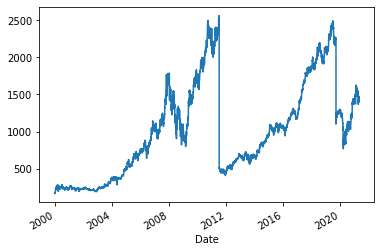

In [9]:
df['Close'].plot()

**Scaling**

In [10]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Prev Close,Open,High,Low,Last,VWAP,Volume_lag_1d
Date,,,,,,,
2000-01-04,0.002747,0.008258,0.006438,0.005841,0.004583,0.005641,0.000320
2000-01-05,0.004329,0.003266,0.002484,0.003338,0.002083,0.003237,0.001667
2000-01-06,0.001478,0.002434,0.000869,0.003463,0.002479,0.002922,0.001579
2000-01-07,0.002040,0.000000,0.001283,0.002149,0.003229,0.002237,0.000835
2000-01-10,0.002060,0.004472,0.004803,0.003338,0.001375,0.002652,0.000836


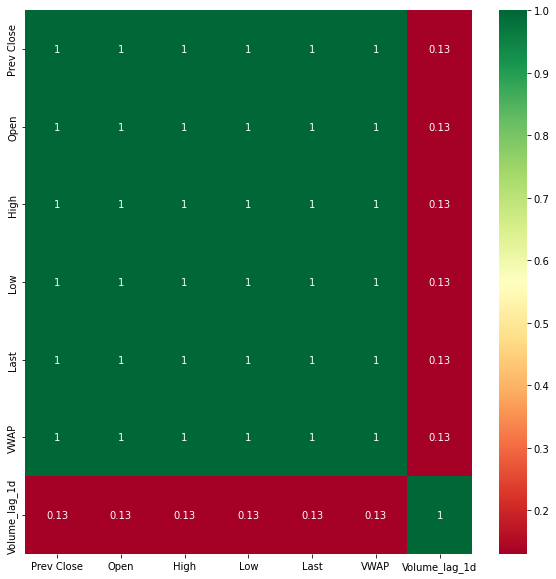

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.subplots(figsize=(10,10))
sns.heatmap(feature_transform.corr(),cmap='RdYlGn',annot=True)
plt.show()

**FIT PCA MODEL,THE NUMBER OF COMPONENTS WILL BE SAME AS NUMBER OF VARIABLES**

In [12]:
from sklearn.decomposition import PCA
pca=PCA().fit(feature_transform[features])
pca

PCA()

In [13]:
str(pca.explained_variance_ratio_.sum())

'1.0'

In [14]:
str(pca.explained_variance_ratio_)

'[9.95755711e-01 3.63148311e-03 4.15370876e-04 9.53678800e-05\n 8.08067886e-05 1.49292113e-05 6.33139389e-06]'

**FIT PCA MODEL,THE NUMBER OF COMPONENTS WILL BE 5 FOR WHICH THE EXPLAINED VARIANCE RATIO.SUM WILL BE 99.99%**

In [15]:
pca=PCA(5).fit(feature_transform)

In [16]:
str(pca.explained_variance_ratio_.sum())

'0.9999787393948255'

In [17]:
str(pca.explained_variance_ratio_)

'[9.95755711e-01 3.63148311e-03 4.15370876e-04 9.53678800e-05\n 8.08067886e-05]'

In [18]:
pca.explained_variance_

array([4.18868680e-01, 1.52759811e-03, 1.74727444e-04, 4.01168856e-05,
       3.39917035e-05])

In [19]:
pca_df=pd.DataFrame(pca.components_,columns=df[features].columns)
pca_df

,Prev Close,Open,High,Low,Last,VWAP,Volume_lag_1d
0,0.408441,0.408354,0.410221,0.405723,0.409175,0.407482,0.008034
1,-0.005728,-0.001642,0.004788,-0.011929,-0.001409,-0.003854,0.999891
2,0.904925,-0.074710,-0.191439,-0.180450,-0.252474,-0.206318,0.002674
3,0.059523,-0.353937,0.596831,-0.657374,0.279383,0.068384,-0.010283
4,0.102593,-0.704926,-0.363657,0.287262,0.491621,0.189899,0.006023


In [20]:
feature_transform.shape

(5305, 7)

In [21]:
#transformed features,instead of having 8,we have 5 now.this can now be plugged into any further modelling work
x_scaled_transf=pca.fit_transform(feature_transform)

In [22]:
x_scaled_transf=pd.DataFrame(x_scaled_transf,columns=('P1','P2','P3','P4','P5'))
x_scaled_transf.shape

(5305, 5)

In [24]:
x_scaled_transf.head()

,P1,P2,P3,P4,P5
0,-0.847020,-0.013728,-0.002550,-0.000630,-0.002757
1,-0.853042,-0.012358,0.001593,-0.000360,-0.000034
2,-0.855125,-0.012437,-0.000673,-0.001191,0.001017
3,-0.856231,-0.013161,0.000125,0.000985,0.002496
4,-0.853060,-0.013163,-0.000696,0.000232,-0.002425


In [25]:
correlation=x_scaled_transf.corr()
correlation

,P1,P2,P3,P4,P5
P1,1.000000e+00,-2.740546e-16,-3.777150e-17,-3.203888e-17,-1.256809e-17
P2,-2.740546e-16,1.000000e+00,2.635884e-16,1.352135e-16,-3.292167e-17
P3,-3.777150e-17,2.635884e-16,1.000000e+00,1.452407e-16,-1.427657e-16
P4,-3.203888e-17,1.352135e-16,1.452407e-16,1.000000e+00,2.842219e-16
P5,-1.256809e-17,-3.292167e-17,-1.427657e-16,2.842219e-16,1.000000e+00


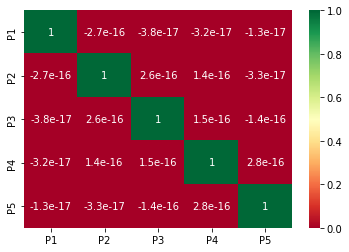

In [26]:
sns.heatmap(correlation,cmap="RdYlGn",annot=True)
plt.show()

In [44]:
feature_transform=x_scaled_transf
feature_transform['Date'] = df.index
feature_transform = feature_transform.set_index('Date')
feature_transform.head()

,P1,P2,P3,P4,P5
Date,,,,,
2000-01-04,-0.847020,-0.013728,-0.002550,-0.000630,-0.002757
2000-01-05,-0.853042,-0.012358,0.001593,-0.000360,-0.000034
2000-01-06,-0.855125,-0.012437,-0.000673,-0.001191,0.001017
2000-01-07,-0.856231,-0.013161,0.000125,0.000985,0.002496
2000-01-10,-0.853060,-0.013163,-0.000696,0.000232,-0.002425


**Splitting to Training set and Test set**

In [28]:
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
  X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
  y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

**Process the data for LSTM**

In [29]:
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

**Building the LSTM Model**

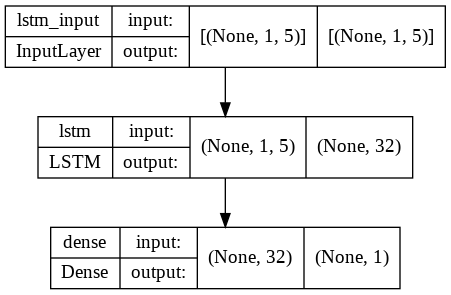

In [30]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

**Model Training**

In [31]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
603/603 [==============================] - 6s 5ms/step - loss: 1329941.7500
Epoch 2/100
603/603 [==============================] - 3s 5ms/step - loss: 1262291.2500
Epoch 3/100
603/603 [==============================] - 3s 5ms/step - loss: 1136180.0000
Epoch 4/100
603/603 [==============================] - 3s 4ms/step - loss: 980366.6250
Epoch 5/100
603/603 [==============================] - 2s 3ms/step - loss: 815796.0625
Epoch 6/100
603/603 [==============================] - 2s 3ms/step - loss: 654649.8750
Epoch 7/100
603/603 [==============================] - 2s 3ms/step - loss: 505380.1875
Epoch 8/100
603/603 [==============================] - 2s 3ms/step - loss: 376091.8750
Epoch 9/100
603/603 [==============================] - 2s 3ms/step - loss: 270097.7500
Epoch 10/100
603/603 [==============================] - 2s 3ms/step - loss: 187675.1562
Epoch 11/100
603/603 [==============================] - 2s 3ms/step - loss: 126516.7734
Epoch 12/100
603/603 [================

**LSTM Prediction**

In [32]:
y_pred= lstm.predict(X_test)


**EVALUATE MODEL PERFORMANCE FOR LSTM**

**MEAN ABSOLUTE ERROR (MAE) FOR TEST DATA**

In [33]:
from sklearn.metrics import mean_absolute_error
print("MEAN ABSOLUTE ERROR (MAE) FOR TEST DATA IS")
np.round(mean_absolute_error(y_pred,y_test),3)

MEAN ABSOLUTE ERROR (MAE) FOR TEST DATA IS


4.366


**MEAN SQUARE ERROR (MSE) FOR TEST DATA**

In [34]:

from sklearn.metrics import mean_squared_error
print("MEAN SQUARE ERROR (MSE) FOR TEST DATA IS")
mse=np.round(mean_squared_error(y_pred,y_test),3)
mse

MEAN SQUARE ERROR (MSE) FOR TEST DATA IS


34.702

**ROOT MEAN SQUARE ERROR (MSE) FOR TEST DATA**

In [35]:
import math
math.sqrt(mse)

5.890840347522584

**MEDIAN ABSOLUTE ERROR (MAE) FOR TEST DATA**

In [36]:
from sklearn.metrics import median_absolute_error
print("MEDIAN ABSOLUTE ERROR (MAE) FOR TEST DATA IS")
np.round(median_absolute_error(y_pred,y_test),3)

MEDIAN ABSOLUTE ERROR (MAE) FOR TEST DATA IS


3.597

**Mean Absolute Percentage Error FOR TEST DATA**

In [37]:
mape = np.mean(np.abs((y_test - y_pred)/y_test))*100
print("MAPE FOR TEST DATA IS")
np.round(mape,3)

MAPE FOR TEST DATA IS


33.435

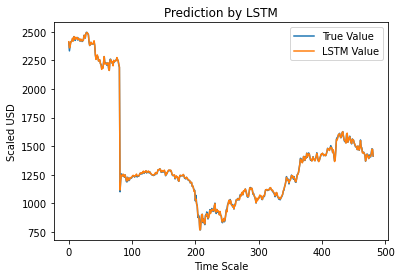

In [38]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [39]:
x_scaled_transf.head()

,P1,P2,P3,P4,P5,Date
0,-0.847020,-0.013728,-0.002550,-0.000630,-0.002757,2000-01-04
1,-0.853042,-0.012358,0.001593,-0.000360,-0.000034,2000-01-05
2,-0.855125,-0.012437,-0.000673,-0.001191,0.001017,2000-01-06
3,-0.856231,-0.013161,0.000125,0.000985,0.002496,2000-01-07
4,-0.853060,-0.013163,-0.000696,0.000232,-0.002425,2000-01-10


In [41]:
#!pip install autokeras

In [45]:
print(x_scaled_transf.shape)
x_scaled_transf=x_scaled_transf.drop(['Date'],axis=1)

(5305, 6)


In [61]:
x_scaled_transf.head()

,P1,P2,P3,P4,P5
0,-0.847020,-0.013728,-0.002550,-0.000630,-0.002757
1,-0.853042,-0.012358,0.001593,-0.000360,-0.000034
2,-0.855125,-0.012437,-0.000673,-0.001191,0.001017
3,-0.856231,-0.013161,0.000125,0.000985,0.002496
4,-0.853060,-0.013163,-0.000696,0.000232,-0.002425


In [62]:
from autokeras import StructuredDataRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [63]:
# basic data preparation
X = x_scaled_transf.astype('float32')
y = output_var.astype('float32') 

In [64]:
# separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4244, 5) (1061, 5) (4244, 1) (1061, 1)


In [65]:
# Initialize the StructuredDataRegressor
reg = StructuredDataRegressor(max_trials=15,overwrite=True,metrics=['mae'])
# Search for the best model.
reg.fit(X_train.to_numpy(),y_train.to_numpy(), validation_split=0.2,epochs=100, verbose=0)

INFO:tensorflow:Oracle triggered exit
Epoch 1/100
133/133 [==============================] - 2s 12ms/step - loss: 807321.6250 - mae: 668.5361
Epoch 2/100
133/133 [==============================] - 2s 12ms/step - loss: 2483.9912 - mae: 33.1603
Epoch 3/100
133/133 [==============================] - 2s 11ms/step - loss: 511.4877 - mae: 16.7824
Epoch 4/100
133/133 [==============================] - 2s 12ms/step - loss: 211.5648 - mae: 10.8499
Epoch 5/100
133/133 [==============================] - 2s 12ms/step - loss: 106.2427 - mae: 7.5438
Epoch 6/100
133/133 [==============================] - 1s 11ms/step - loss: 62.1446 - mae: 5.5872
Epoch 7/100
133/133 [==============================] - 2s 12ms/step - loss: 41.7067 - mae: 4.4190
Epoch 8/100
133/133 [==============================] - 2s 11ms/step - loss: 31.3647 - mae: 3.7042
Epoch 9/100
133/133 [==============================] - 1s 11ms/step - loss: 25.7355 - mae: 3.2662
Epoch 10/100
133/133 [==============================] - 2s 12ms/st

In [66]:
predicted = reg.predict(X_test)

34/34 [==============================] - 0s 4ms/step


In [67]:
# evaluate the model
loss, acc =reg.evaluate(X_train,y_train, verbose=0)
print('Accuracy: %.3f' % acc)
print('loss: %.3f' % loss)


Accuracy: 2.746
loss: 18.271


**EVALUATE MODEL PERFORMANCE FOR AutoKeras**

**MEAN ABSOLUTE ERROR (MAE) FOR TEST DATA**

In [68]:
from sklearn.metrics import mean_absolute_error
print("MEAN ABSOLUTE ERROR (MAE) FOR TEST DATA IS")
np.round(mean_absolute_error(predicted,y_test),3)

MEAN ABSOLUTE ERROR (MAE) FOR TEST DATA IS


2.808

**MEAN SQUARE ERROR (MSE) FOR TEST DATA**

In [69]:
from sklearn.metrics import mean_squared_error
print("MEAN SQUARE ERROR (MSE) FOR TEST DATA IS")
mse=np.round(mean_squared_error(predicted,y_test),3)
mse

MEAN SQUARE ERROR (MSE) FOR TEST DATA IS


20.38

**ROOT MEAN SQUARE ERROR (MSE) FOR TEST DATA**

In [70]:
import math
math.sqrt(mse)

4.51442124316801

**MEDIAN ABSOLUTE ERROR (MAE) FOR TEST DATA**

In [71]:
from sklearn.metrics import median_absolute_error
print("MEDIAN ABSOLUTE ERROR (MAE) FOR TEST DATA IS")
np.round(median_absolute_error(predicted,y_test),3)

MEDIAN ABSOLUTE ERROR (MAE) FOR TEST DATA IS


1.734

**Mean Absolute Percentage Error FOR TEST DATA**

In [73]:
print("MAPE FOR TEST DATA IS")
mape1 = np.mean(np.abs((y_test - predicted)/y_test))*100
np.round(mape1,3)

MAPE FOR TEST DATA IS


Close    0.319
dtype: float32

**Get the best performing model and Summarize the loaded model**

In [74]:
keras_model = reg.export_model()
keras_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 5)                0         
 ltiCategoryEncoding)                                            
                                                                 
 dense (Dense)               (None, 512)               3072      
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 re_lu_1 (ReLU)              (None, 1024)              0         
                                                             

**View the visual representation of the model**

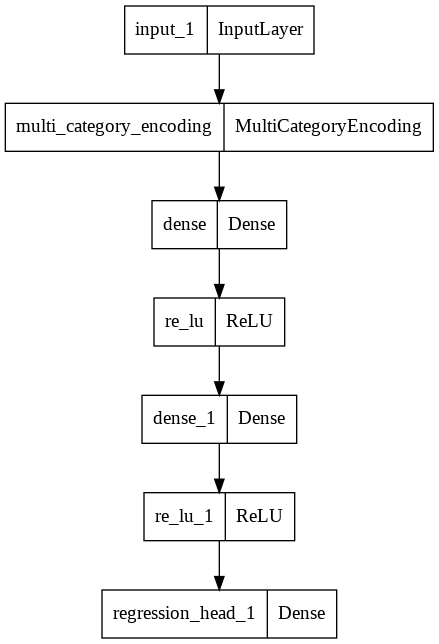

In [75]:
import tensorflow as tf
tf.keras.utils.plot_model
plot_model(keras_model)

In [76]:
!jupyter nbconvert StockMarketPrediction_PCA_LSTM_AutoKeras.ipynb

[NbConvertApp] Converting notebook StockMarketPrediction_PCA_LSTM_AutoKeras.ipynb to html
[NbConvertApp] Writing 539581 bytes to StockMarketPrediction_PCA_LSTM_AutoKeras.html
